# Prediction using GBM

##### loading libraries

In [7]:
library(data.table)
library(caret)
library(pROC)

##### loading datasets

In [8]:
load("../data_processed/projetDataBase.Rda")
projetTrain    = sub.projetTrain.base
projetValid    = sub.projetValid.base

##### making subsets for train and test of our TRAIN DATA

In [9]:
set.seed(30)
split = sample(nrow(projetTrain), floor(0.1*nrow(projetTrain)))
sub.train = projetTrain[split,]
sub.test  = projetTrain[-split,]

##### defining train control and control grid

In [10]:
trctrl = trainControl(
                     method = 'repeatedcv',
                     number = 3,
                     returnResamp='none',
                     summaryFunction = twoClassSummary,
                     allowParallel = TRUE,
                     classProbs = TRUE
                     )

In [11]:
grid = expand.grid(
                  n.trees=c(1000,250),
                  interaction.depth = 4,
                  shrinkage = 0.1,
                  n.minobsinnode = 10
                  )

##### Computing the GBM model

In [ ]:
gbm.model = train(target~.,
              method = "gbm",
              data = sub.train,
              trControl = trctrl,
              metric = "ROC",
              tuneGrid = grid
             )

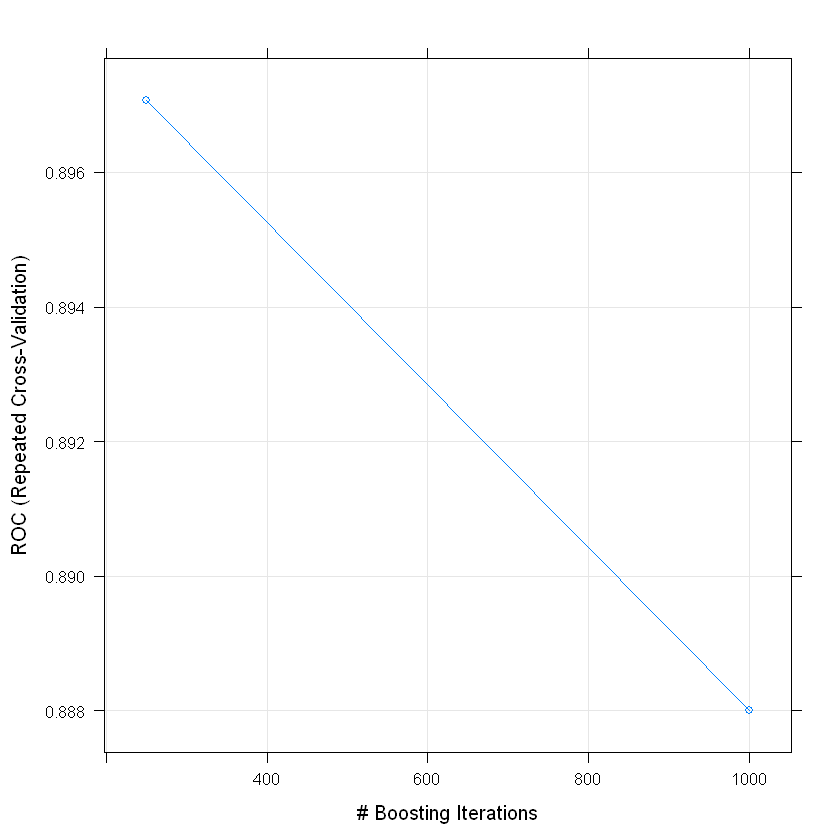

In [14]:
plot(gbm.model) # visialusation des performances 

##### model description

In [15]:
gbm.model

Stochastic Gradient Boosting 

5138 samples
 129 predictor
   2 classes: 'KO', 'OK' 

No pre-processing
Resampling: Cross-Validated (3 fold, repeated 1 times) 
Summary of sample sizes: 3426, 3425, 3425 
Resampling results across tuning parameters:

  n.trees  ROC        Sens       Spec     
   250     0.8970611  0.8599537  0.7336442
  1000     0.8880142  0.8553241  0.7229437

Tuning parameter 'interaction.depth' was held constant at a value of 4

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
ROC was used to select the optimal model using  the largest value.
The final values used for the model were n.trees = 250, interaction.depth =
 4, shrinkage = 0.1 and n.minobsinnode = 10. 

##### Prediction on test subset

In [16]:
result.predicted.prob <- predict(gbm.model, sub.test , type="prob") # Prediction

##### AUC curve


Call:
roc.default(response = sub.test$target, predictor = result.predicted.prob$OK)

Data: result.predicted.prob$OK in 31047 controls (sub.test$target KO) < 15196 cases (sub.test$target OK).
Area under the curve: 0.9049

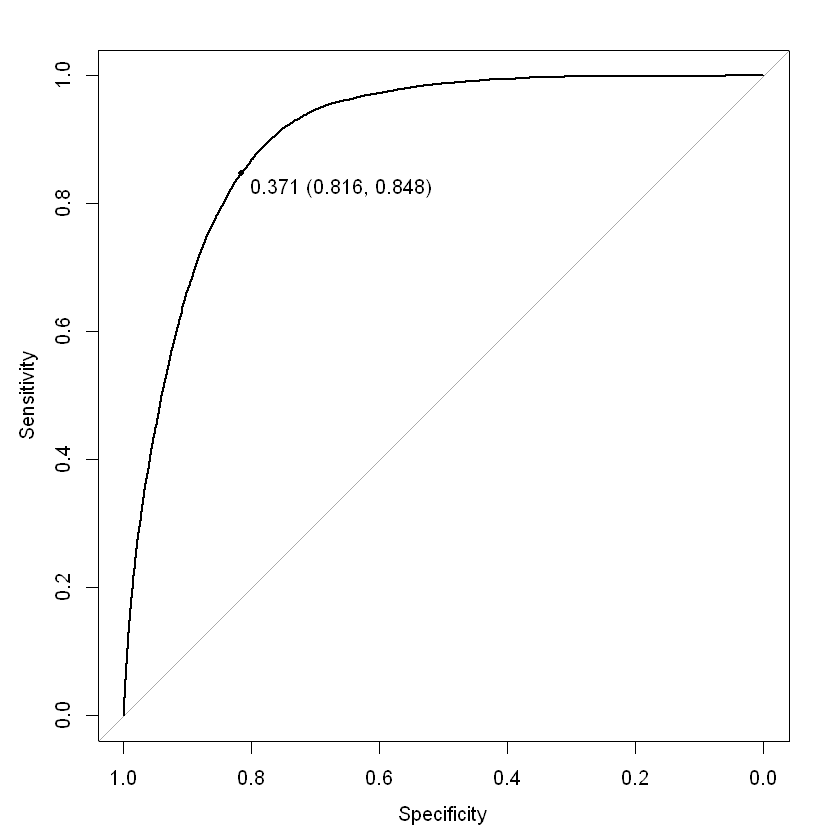

In [17]:
result.roc <- roc(sub.test$target, result.predicted.prob$OK) # Draw ROC curve.
plot(result.roc, print.thres="best", print.thres.best.method="closest.topleft")

In [20]:
result.coords <- coords(result.roc, "best", best.method="closest.topleft", ret=c("threshold", "accuracy"))
print(result.coords)#to get threshold and accuracy

threshold  accuracy 
0.3711374 0.8266548 


##### Saving model 

In [18]:
save(gbm.model, file="gbm.model.Rdata")

##### generating the response for the validation subset

In [19]:
result.predicted.prob.valid <- predict(gbm.model, projetValid , type="prob") # Prediction on validation subset
projetValid$Id = as.character(projetValid$Id)
validation.results = cbind(projetValid[,"Id",with=FALSE],result.predicted.prob.valid)
write.csv(validation.results, file = "validation_results.csv")